In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice
import random

In [3]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from pytorch_lightning.loggers import WandbLogger

from estimator import LagTransformerEstimator

In [4]:
class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

In [5]:
class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)
    
    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

In [15]:
gluonts_ds = [
        get_dataset("airpassengers").train,
        get_dataset("australian_electricity_demand").train,
        get_dataset("car_parts_without_missing").train,
        get_dataset("cif_2016").train,
        get_dataset("covid_deaths").train,
        get_dataset("electricity").train,
        get_dataset("electricity_weekly").train,
        get_dataset("exchange_rate").train,
        get_dataset("fred_md").train,
        get_dataset("hospital").train,
        get_dataset("kaggle_web_traffic_weekly").train,
        get_dataset("kdd_cup_2018_without_missing").train,
        get_dataset("london_smart_meters_without_missing").train,
        get_dataset("nn5_daily_with_missing").train,
        get_dataset("nn5_weekly").train,
        get_dataset("pedestrian_counts").train,
        get_dataset("rideshare_without_missing").train,
        get_dataset("saugeenday").train,
        get_dataset("solar-energy").train,
        get_dataset("solar_10_minutes").train,
        get_dataset("solar_weekly").train,
        get_dataset("taxi_30min").train,
        get_dataset("temperature_rain_without_missing").train,
        get_dataset("tourism_monthly").train,
        get_dataset("uber_tlc_daily").train,
        get_dataset("uber_tlc_hourly").train,
        get_dataset("vehicle_trips_without_missing").train,
        get_dataset("weather").train,
        get_dataset("wiki-rolling_nips").train,
        get_dataset("m4_daily").train,
        get_dataset("m4_hourly").train,
        get_dataset("m4_monthly").train,
        get_dataset("m4_quarterly").train,
        get_dataset("m4_yearly").train,
        get_dataset("wind_farms_without_missing").train,
]
dataset = CombinedDataset(gluonts_ds)

In [7]:
#dataset = get_dataset("electricity").train

In [16]:
val_dataset = get_dataset("traffic").train

In [38]:
test_dataset = get_dataset("traffic").test

In [37]:
meta = get_dataset("m4_weekly").metadata

In [19]:
meta

MetaData(freq='W', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='359')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=13)

In [20]:
estimator = LagTransformerEstimator(
    prediction_length=meta.prediction_length,
    context_length=1024, # block_size: int = 2048 
    batch_size=16, # 4
    num_encoder_layers=8,
    num_decoder_layers=4,
    nhead=4,
    d_model=64, # 4096
    dim_feedforward=64*4,
    scaling="std",
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", precision="bf16-mixed", logger=WandbLogger()),
)

In [21]:
predictor = estimator.train(
    training_data=dataset, 
    validation_data=val_dataset,
    shuffle_buffer_length=1000
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./lightning_logs/tfbgiurs/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LagTransf

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'val_loss' reached -2.20977 (best -2.20977), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' reached -2.25420 (best -2.25420), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=1-step=200-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 300: 'val_loss' reached -2.65720 (best -2.65720), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=2-step=300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 600: 'val_loss' reached -2.90094 (best -2.90094), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=5-step=600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 800: 'val_loss' reached -3.03744 (best -3.03744), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=7-step=800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 2100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 2400: 'val_loss' reached -3.06831 (best -3.06831), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=23-step=2400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 2500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 2700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 2800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 2900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 3000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 3300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3400: 'val_loss' reached -3.08077 (best -3.08077), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=33-step=3400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 3600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 3700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 3800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 3900: 'val_loss' reached -3.09639 (best -3.09639), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=38-step=3900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 4400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 4500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 4600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 4700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 4800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 4900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 5100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 5200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 5300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 5400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 5500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 5600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 5700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 5800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 5900: 'val_loss' reached -3.11008 (best -3.11008), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=58-step=5900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 6000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 6100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 6200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 6300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 6400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 6500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 6600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 6700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 6800: 'val_loss' reached -3.15671 (best -3.15671), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=67-step=6800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 6900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 7000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 7100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 7200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 7300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 7400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 7500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 75, global step 7600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 7700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 7800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 7900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 8000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 8100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 8200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 8300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 8400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 8500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 8600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 8700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 8800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 8900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 9000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 9100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 9200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 9300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 9400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 9500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 9600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 9700: 'val_loss' reached -3.16913 (best -3.16913), saving model to './lightning_logs/tfbgiurs/checkpoints/epoch=96-step=9700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 9800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 9900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 10000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


In [39]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset, predictor=predictor
)

In [40]:
forecasts = list(forecast_it)

In [41]:
tss = list(ts_it)

In [42]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(
    iter(tss), iter(forecasts), num_series=len(test_dataset)
)


Running evaluation: 100%|█████████████████████████████████| 6034/6034 [00:00<00:00, 84733.41it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"])

In [43]:
agg_metrics

{'MSE': 0.0014219918296217323,
 'abs_error': 1509.3492883965373,
 'abs_target_sum': 6499.166794961318,
 'abs_target_mean': 0.08285315003392721,
 'seasonal_error': 0.015216390383237022,
 'MASE': 1.2300741428936501,
 'MAPE': 0.22449981010746844,
 'sMAPE': 0.21313223437928785,
 'MSIS': 14.478915659350704,
 'QuantileLoss[0.1]': 787.4221241879393,
 'Coverage[0.1]': 0.011524438438591572,
 'QuantileLoss[0.2]': 1080.0002269773745,
 'Coverage[0.2]': 0.05505978939853651,
 'QuantileLoss[0.3]': 1270.3887665494344,
 'Coverage[0.3]': 0.15782361490018101,
 'QuantileLoss[0.4]': 1411.6902237966656,
 'Coverage[0.4]': 0.3045817291756967,
 'QuantileLoss[0.5]': 1509.3492891977075,
 'Coverage[0.5]': 0.46940414573825245,
 'QuantileLoss[0.6]': 1546.3581433156505,
 'Coverage[0.6]': 0.6170546390964025,
 'QuantileLoss[0.7]': 1505.2034648987465,
 'Coverage[0.7]': 0.7694347415925141,
 'QuantileLoss[0.8]': 1351.1494096877052,
 'Coverage[0.8]': 0.8771448968664746,
 'QuantileLoss[0.9]': 993.6272496377115,
 'Coverage[

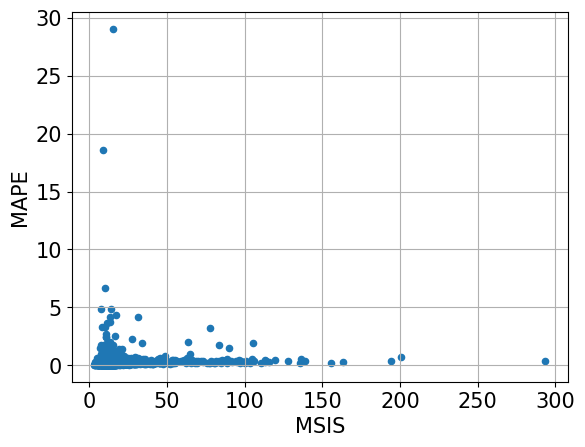

In [44]:
ts_metrics.plot(x="MSIS", y="MAPE", kind="scatter")
plt.grid(which="both")
plt.show()

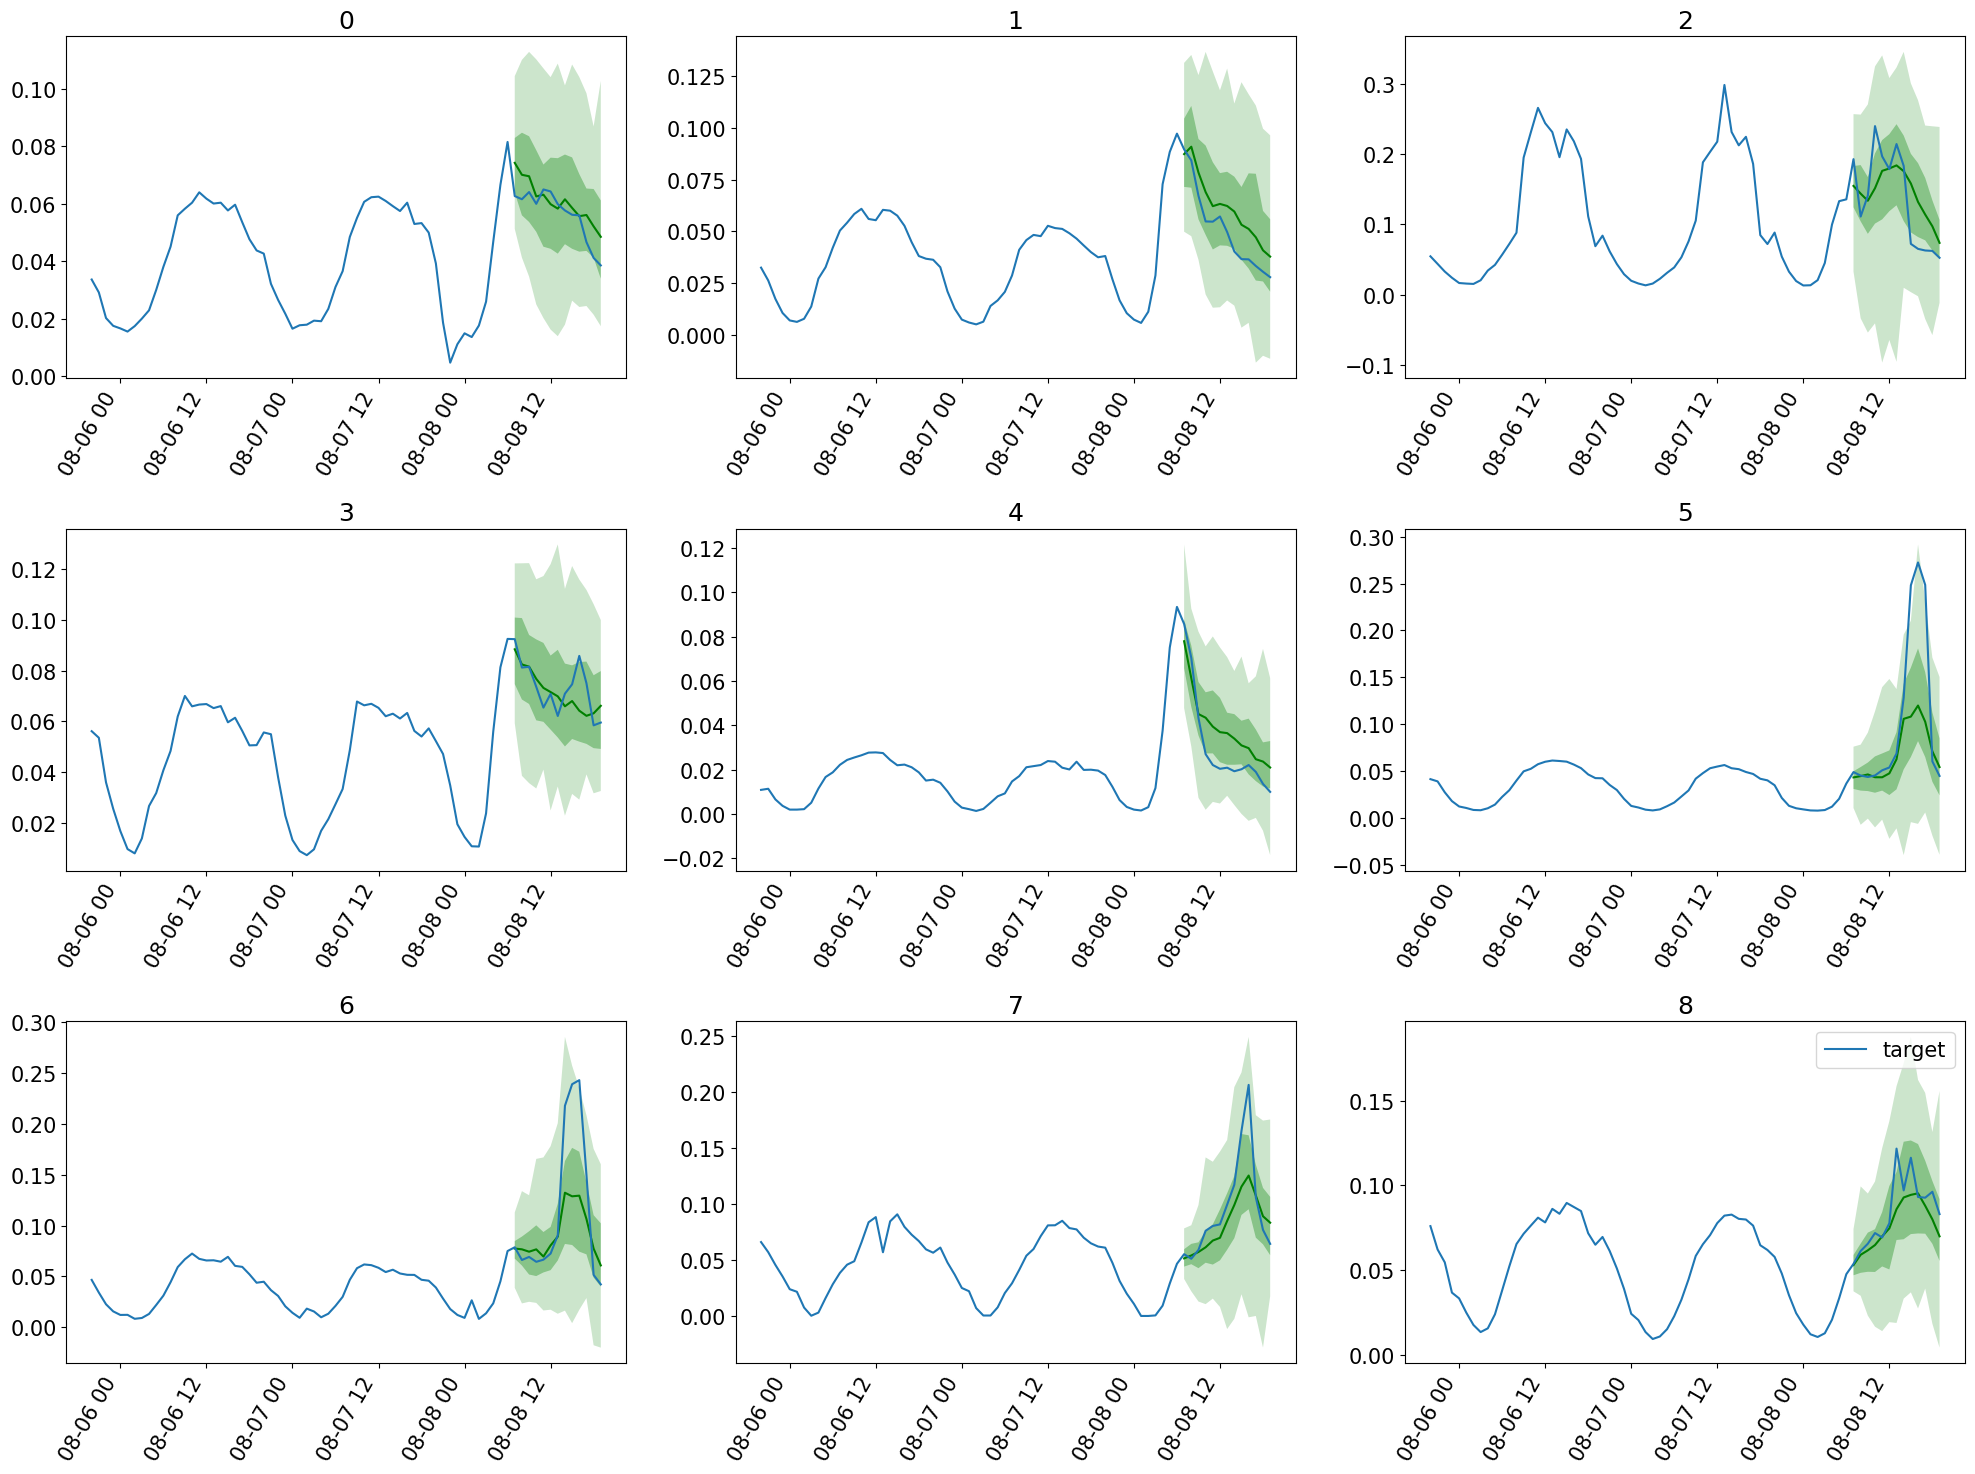

In [45]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * 24:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()